In [150]:
import os
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt

<hr>

#### read in and prepare Haxby data

In [151]:
# prepare Haxby data (see slides on Brightspace for details)

def prep_haxby_data(dirpath = ''):
    ### load the functional MRI patterns ###

    # every 2.5 seconds the scanner records a full brain image
    # we have extracted just voxels in ventral temporal lobe
    # row number corresponds to image number / time point
    # column number corresponds to voxel number within ventral temporal lobe
    # there should be 1452 images, and 32450 voxels
    full_patterns = np.load(dirpath + 'haxby_vt_patterns.npy')
    n_img = full_patterns.shape[0]
    n_vox = full_patterns.shape[1]

    """
    plt.plot(full_patterns[:, 10000])
    mean = [np.mean(full_patterns[:, 10000])] * n_img
    plt.plot(mean)
    plt.show()
    """
    # if an fMRI experiment takes an hour, you usually wouldn't run 
    # the scanner for an hour straight
    # usually, you would run it for a block of time (several minutes) 
    # called a 'run'
    # each run contains a chunk of the experiment
    # if there are several conditions in your experiment, usually you 
    # try to put each condition within each run
    # Haxby et al had 8 experimental conditions, one condition for each 
    # of the 8 categories they used - they had 12 runs, and within each 
    # run they presented a block of images from the each category.
    n_runs = 12

    ### processing the experimental design ###
    
    # Haxby et al. provide a text file 'labels.txt' which says when 
    # they presented items from one category or another
    # labels.txt has 1453 lines.  
    # the first line is header information  
    # then there are 1452 lines, one for each image, saying what was 
    # happening in the experiment at that time point
    # each line specifies the category name / condition, and the run 
    # number (though the header calls this "chunks")
    # aside from the 8 categories, there is also time when the screen was 
    # blank, in between category presentations
    # they call this 'rest'; we will exclude rest images from our classification

    # a bunch of items from the same category would be presented one 
    # after another
    # so if you look at labels.txt, you'll see there will be 9 lines in a 
    # row that all say 'scissors'

    # read the labels.txt file
    fid = open(dirpath + 'labels.txt', 'r')
    # this command reads in the first line of the file, the header, 
    # which we don't need 
    temp = fid.readline()

    # these are the 9 different strings that appear in labels.txt
    cond_names = ['face', 'house', 'cat', 'shoe', 'scissors', 'bottle', 
                  'scrambledpix', 'chair', 'rest']
    # this will store the 'one-hot' target values for the classifier
    all_targets = np.zeros([n_img, len(cond_names)])
    # this will store the run index
    all_runs = np.zeros([n_img,])

    # now we iterate through the 1452 lines in labels.txt
    # line.split breaks the string into 2 parts
    # the first is 'this_cond' which says which category/condition (or rest)
    # the second is 'this_run' which tells you the functional run of this image 
    imgcount = 0
    for line in fid:
        temp = line.split()
        this_cond = temp[0]
        this_run = temp[1]
        all_targets[imgcount, cond_names.index(this_cond)] = 1
        all_runs[imgcount] = int(this_run)
        imgcount += 1

    ### cheap version of accounting for the hemodynamic lag ###

    # as we reviewed in lecture, there is a lag from when a stimulus is 
    # presented, to when the brain's vasculature has its peak response
    # one can properly take this hemodynamic lag into account, but we 
    # are going to do a short-cut
    # if each image takes 2.5 seconds to acquire, and it takes about 5 
    # seconds for the brain to reach its peak response, we can shift the 
    # condition labels forward by two images
    # an easy way to do this is to concatenate 2 rows of zeros at the 
    # beginning of the targets matrix and then remove 2 rows of zeros 
    # from the end of the targets matrix
    # that pushes every label forward by 5 seconds
    
    # just shift all the regressors over by 2 time points
    # each image takes 2.5 seconds to acquire
    prepend_zeros = np.zeros([2, all_targets.shape[1]])
    shift_all_targets = np.concatenate((prepend_zeros, all_targets))
    mask = np.ones(shift_all_targets.shape[0], dtype=bool)
    mask[shift_all_targets.shape[0]-2:shift_all_targets.shape[0]] = False
    shift_all_targets = shift_all_targets[mask, :]
    
    # now that we are done just replace the original target labels 
    # with the shifted ones
    all_targets = shift_all_targets

    ### remove rests from runs ###
    
    # modify the labels matrix
    # remove the rest unit, we don't want to classify rest patterns
    temp_targets = all_targets[:, :8].copy()
    # get rid of images where there isn't a category being presented
    # and make it a boolean array
    label_present = np.sum(temp_targets, axis=1)> 0

    # label_present is a boolean array indicating when a category is 
    # being presented
    # we are using it as a mask to get rid of all the time-points 
    # where nothing is being presented
    # in other words it gets rid of all the rest periods
    targets = temp_targets[label_present, :]
    patterns = full_patterns[label_present, :]
    runs = all_runs[label_present]
    
    ### z-scoring is a kind of normalization ###
    n_vox = patterns.shape[1]
    for i in range(n_vox):
        patterns[:,i] = (patterns[:,i] - patterns[:,i].mean()) / patterns[:,i].std()

    # for a set of numbers, get the mean and standard deviation
    # subtract the mean off every number, divide every number 
    # by the standard deviation
    # here we normalize our patterns using a temporal z-score,
    # meaning that we normalize the values for each voxel, across time    
    
    # here are the arrays you need to do classification
    return patterns, targets, runs

patterns.shape, targets.shape, runs.shape<br>
864 : number of fMRI brain scans (onebrain scan per object image)<br>
32450 : number voxels in IT cortex (using an anatomical mask)<br>
8 : number of object categories (face, house, cat, shoe, scissors, bottle, scrambled, chair, rest)

patterns: contains voxel (fMRI) data

targets: contains the condition (category) associated with each fMRI scan

runs: which "run" each scan is associated with

In [204]:
# load Haxby et al. data (see slides on Brightspace)

patterns, targets, runs = prep_haxby_data()

print(patterns.shape)
print(targets.shape)
print(runs.shape)

cond_names = ['face', 'house', 'cat', 'shoe', 'scissors', 'bottle',
              'scrambledpix', 'chair', 'rest']

(864, 32450)
(864, 8)
(864,)


<hr>

#### "feature selection"

with "feature selection", selecting voxels that modulate statistically significantly according to object category

In [153]:
# "feature selection" based on picking statistically significant voxels

def feature_selection(train_pats, train_targs, test_pats):
    pval = 0.1
    
    keep_these = np.zeros((train_pats.shape[1],))
    
    # loop through every voxel
    for v in range(train_pats.shape[1]):
        groups = []
        for c in range(train_targets.shape[1]): # train_targets.shape[1] == 72*11 = 794
            groups.append(train_pats[train_targs[:, c] == 1., v])
           
        # and statistically analyze it for category modulation
        temp = sps.f_oneway(groups[0], groups[1], groups[2], groups[3],
                            groups[4], groups[5], groups[6], groups[7])

        if temp.pvalue < pval:
            keep_these[v] = 1.
    
    keep_these = keep_these.astype(bool)
    train_pats = train_pats[:, keep_these]
    test_pats = test_pats[:, keep_these]
    
    return train_pats, test_pats

<hr>

#### some starting points for Q1 

(see slides on Brightspace from class for details)

In [154]:
# an example "leaving out" a particular run

example_test_run = 1

train_these = runs != example_test_run
test_these  = runs == example_test_run

# an example of logical indexing
train_patterns = patterns[train_these, :]
train_targets = targets[train_these, :]

test_patterns = patterns[test_these, :]
test_targets = targets[test_these, :]

print(test_patterns.shape)

(72, 32450)


In [157]:
# "feature selection" of statistically category-modulated voxels

fs_train_patterns, fs_test_patterns = feature_selection(train_patterns,
                                                        train_targets,
                                                        test_patterns)

In [158]:
fs_train_patterns.shape

(792, 12763)

In [159]:
print(fs_train_patterns.shape)
print(train_targets.shape)
print(fs_test_patterns.shape)
print(test_targets.shape)

(792, 12763)
(792, 8)
(72, 12763)
(72, 8)


In [160]:
# report some metrics on Haxby experiment (n_vox is for this fold)

n_runs = np.max(runs).astype('int') + 1
n_vox  = fs_train_patterns.shape[1]
n_cats = targets.shape[1]

cond_names = ['face', 'house', 'cat', 'shoe', 'scissors', 'bottle', 
              'scrambledpix', 'chair', 'rest']

print(n_runs)
print(n_vox)
print(n_cats)

12
12763
8


# Part 1a)
Run MVPA on fmri data for Haxby participant using leave-one-out cross validation

In [224]:
## Define a function that get's one fold's worth of training and testing inputs/outputs

def get_fold_data(fold, targets_arr):
    # Create a boolean mask to select rows that will be used for training / testing
    # Boolean mask will be dependent on the runs
    # Selecting all images not from the testing run 
    is_train = (runs != fold)
    is_test = (runs == fold)

    f_training_patterns = patterns[is_train, :]
    f_training_targets = targets_arr[is_train, :]

    f_testing_patterns = patterns[is_test, :]
    f_testing_targets = targets_arr[is_test, :]

    # Running feature selection on training and testing patterns

    # Get rid of voxels in fmri patterns that whose mean BOLD signal does not significantly vary across categories
    f_train_pats, f_test_pats = feature_selection(f_training_patterns, f_training_targets, f_testing_patterns)
    return f_train_pats, f_training_targets, f_test_pats, f_testing_targets

In [225]:
# Run the feature selection for each of the folds (save some time)
fold_data = [get_fold_data(i, targets) for i in range(n_runs)]
fold_training_pats = [fold_data[i][0] for i in range(n_runs)]
fold_training_targets = [fold_data[i][1] for i in range(n_runs)]
fold_testing_pats = [fold_data[i][2] for i in range(n_runs)]
fold_testing_targets= [fold_data[i][3] for i in range(n_runs)]
print(len(fold_training_pats[3][0]))

12432


In [216]:
# Create a classification network that can be trained and evaluated on training and testing data of a fold
import tensorflow as tf
from tensorflow.keras import models, layers

n_folds = n_runs
n_categories = len(targets[0, :])

def create_classifier(fold, train_pats, train_targets):
    f = fold
    nin = len(train_pats[0])


    classifier = models.Sequential()

    classifier.add(
        layers.Dense(
            n_categories,
            activation="softmax",
            input_shape=(nin,),
            kernel_regularizer= tf.keras.regularizers.l2(0.001)
        )
    )

    # compile the network - categorical cross entropy (loss)
    classifier.compile(
        loss="categorical_crossentropy",
        optimizer="sgd",
        metrics= ['categorical_crossentropy', 'accuracy']
    )

    # Train network
    history = classifier.fit(
        x=train_pats,
        y=train_targets,
        epochs=7,
        verbose=None
    )
    return classifier
    

*Epoch Justification* - Loss flattens when epoch > `7`

In [219]:
def accuracy_on_categories(classifier, test_pats, test_targets):
   # """Test classifier on testing set by return accuracy for each of the 8 categories"""
    # How can we separate out the classifier performance across categories
    category_accuracy = [] 

    for i in range(n_categories):
        boolean_mask = test_targets[:, i] == 1
        cat_pats = test_pats[boolean_mask, :]
        cat_targs = test_targets[boolean_mask, :]

        history = classifier.evaluate(
            x=cat_pats,
            y =cat_targs
        )
        category_accuracy.append(history[2])
    
    return category_accuracy


In [ ]:
n_iter = 5
accuracy_matrix = np.zeros((n_iter, n_folds, n_categories))

for iter in range(n_iter):
    for f in range(n_folds):
        # Run classifier training function
        classifier = create_classifier(f, fold_training_pats[f], fold_training_targets[f])
        # Run classifier analysis function
        category_accuracy = accuracy_on_categories(classifier, fold_testing_pats[f], fold_testing_targets[f])
        accuracy_matrix[iter, f, :] = np.array(category_accuracy)


In [221]:

print(f"""########## SUMMARY ##########
Overall performance: {np.mean(accuracy_matrix)}
""")

iter_acc = [] 
cat_acc = []
fold_acc = []

print("Average Classification on:")
for i in range(n_iter):
    print(f"(iteration) {i+1}: {np.mean(accuracy_matrix[i, :, :])}")
    iter_acc.append(np.mean(accuracy_matrix[i, :, :]))

print("")

for i in range(n_categories):
    print(f"(category) {cond_names[i]}: {np.mean(accuracy_matrix[:, :, i])}")
    cat_acc.append(np.mean(accuracy_matrix[:, :, i]))

print()

for i in range(n_folds):
    print(f"(fold) {i + 1}: {np.mean(accuracy_matrix[:, i, :])}",)
    fold_acc.append(np.mean(accuracy_matrix[:, i, :]))


########## SUMMARY ##########
Overall performance: 0.46504630325362084

Average Classification on:
(iteration) 1: 0.45023148817320663
(iteration) 2: 0.46064815561597544
(iteration) 3: 0.4444444510154426
(iteration) 4: 0.46875000675208867
(iteration) 5: 0.501157414711391

(category) face: 0.6592592665304741
(category) house: 0.6814814894149701
(category) cat: 0.4277777829517921
(category) shoe: 0.1555555594464143
(category) scissors: 0.38888889787097775
(category) bottle: 0.1648148181537787
(category) scrambledpix: 0.675925936549902
(category) chair: 0.566666675110658

(fold) 1: 0.35555556081235407
(fold) 2: 0.4722222272306681
(fold) 3: 0.5166666755452752
(fold) 4: 0.6055555626749992
(fold) 5: 0.5083333412185311
(fold) 6: 0.6333333428949117
(fold) 7: 0.5055555641651154
(fold) 8: 0.46666667610406876
(fold) 9: 0.45000000633299353
(fold) 10: 0.3805555611848831
(fold) 11: 0.3416666708886623
(fold) 12: 0.3444444499909878


<BarContainer object of 12 artists>

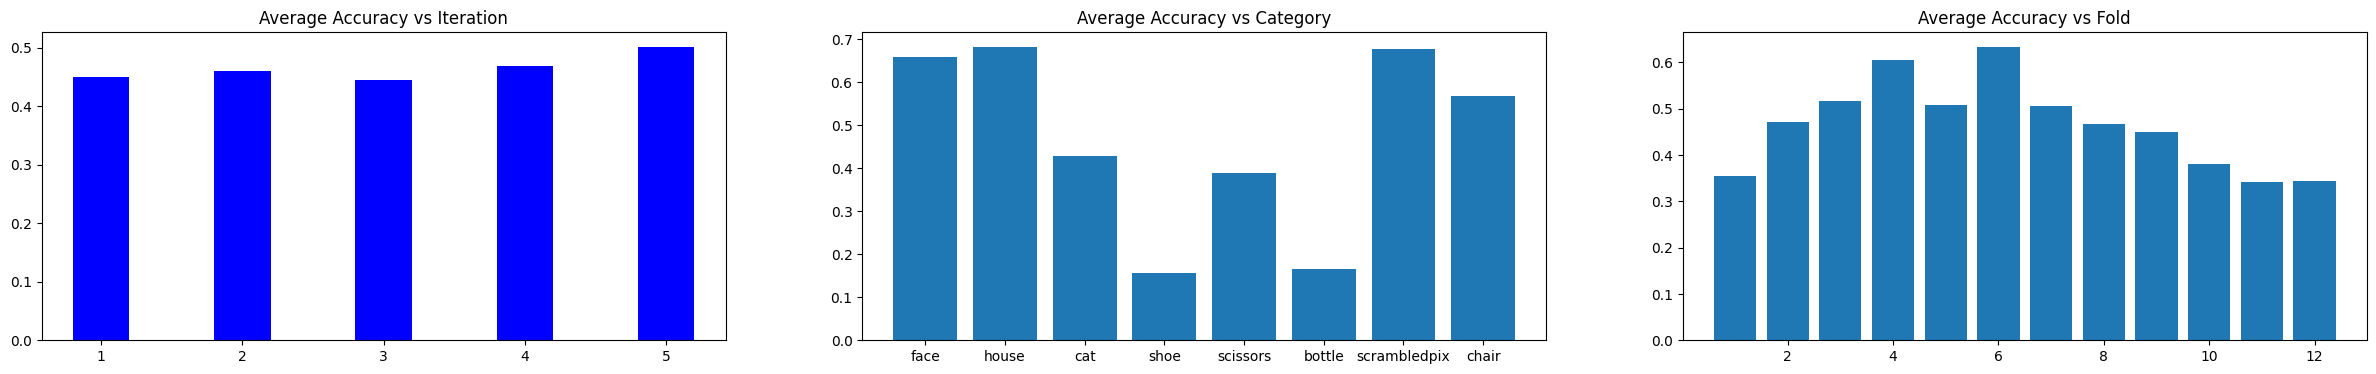

In [222]:
plt.figure(figsize=(30,4))
plt.subplot(1,3,1)
plt.title("Average Accuracy vs Iteration")
plt.bar(np.arange(1,6), iter_acc, width=.4, color="blue")
plt.subplot(1,3,2)
plt.title("Average Accuracy vs Category")
plt.bar(cond_names[:-1], cat_acc)
plt.subplot(1,3,3)
plt.title("Average Accuracy vs Fold")
plt.bar(np.arange(1,13), fold_acc)

In [223]:
print("Variance across iteration accuracies", np.std(np.multiply(100, iter_acc)), "(%)")
print("Variance across category accuracies", np.std(np.multiply(100, cat_acc)), "(%)")

Variance across iteration accuracies 1.9904715795374641 (%)
Variance across category accuracies 20.386029002012307 (%)


### Observations

*Overall Performance*
* Overall performance of `46%` seems significantly higher than chance classification `12.5%`, this indicates category specific activity in IT 

*Iterations*
* The average value across each iteration does not vary much, with standard deviation of about `1.2`

*Categories*
* `Shoe` and `Bottle` had worse classification performance (about chance). 
* `Face`, `house`, `chair`, and `scram`x had high classification accuracies (above $.6$)
* Much more variance across categories than iterations

* Folds towards the beginning (`1`) and end (`10`, `11`, `12`) seem to have worse classification performance
    * perhaps because participant was less prepared towards beginning or task-focused towards end)



## Part 1b)

<hr>

#### function to scramble targets for permutation test

(as described in class)

In [214]:
# how to scramble the category labels for a permutation analysis

def scramble_targets(targets, runs):
    # there are 12 runs
    n_runs = np.max(runs).astype('int') + 1
    
    # there are 8 categories
    n_cats = targets.shape[1]
    
    # this will contain the scrambled category labels
    scram_targets = np.zeros(targets.shape)
    
    for i in range(n_runs):
        # first find the category labels just for this run
        these_targets = targets[runs==i, :].copy()
        
        # this shuffles the columns of these_targets, which preserves 
        # the block structure of the experiment
        scram_targets_this_run = these_targets[:, np.random.permutation(n_cats)] # you can index into an array using a tuple
        
        # this copies the scrambled targets for this run into the 
        # appropriate rows of the scrambled category labels matrix
        scram_targets[runs==i,:] = scram_targets_this_run

    return scram_targets

In [215]:
scram_targets = scramble_targets(targets, runs)

In [194]:
example_test_run = 3

train_these = runs != example_test_run
test_these  = runs == example_test_run

# an example of logical indexing
train_patterns = patterns[train_these, :]
scram_train_targets = scram_targets[train_these, :]

test_patterns = patterns[test_these, :]
test_targets = targets[test_these, :]

In [195]:
fs_train_patterns, fs_test_patterns = feature_selection(train_patterns,
                                                        scram_train_targets,
                                                        test_patterns)

n_vox  = fs_train_patterns.shape[1]

In [226]:
scram_targets = scramble_targets(targets, runs)

# Create the feature-selected training and testing patterns for each fold
fold_data = [get_fold_data(i, scram_targets) for i in range(n_runs)]
fold_training_pats = [fold_data[i][0] for i in range(n_runs)]
fold_training_targets = [fold_data[i][1] for i in range(n_runs)]
fold_testing_pats = [fold_data[i][2] for i in range(n_runs)]
fold_testing_targets= [fold_data[i][3] for i in range(n_runs)]

In [ ]:
permutation_accuracies = []
n_perm = 5

for i in range(n_perm):
    perm_accuracy_matrix = np.zeros((n_iter, n_folds, n_categories))
    for iter in range(n_iter):
        for f in range(n_folds):
            # Run classifier training function
            classifier = create_classifier(f, fold_training_pats[f], fold_training_targets[f])
            # Run classifier analysis function
            category_accuracy = accuracy_on_categories(classifier, fold_testing_pats[f], fold_testing_targets[f])
            perm_accuracy_matrix[iter, f, :] = np.array(category_accuracy)
    mean = np.mean(perm_accuracy_matrix)
    permutation_accuracies.append(mean)


In [246]:
print(permutation_accuracies[:5])

[0.1361111134601136, 0.13101852082957824, 0.12893518734102447, 0.14143518766698737, 0.13402778000260393]


<BarContainer object of 6 artists>

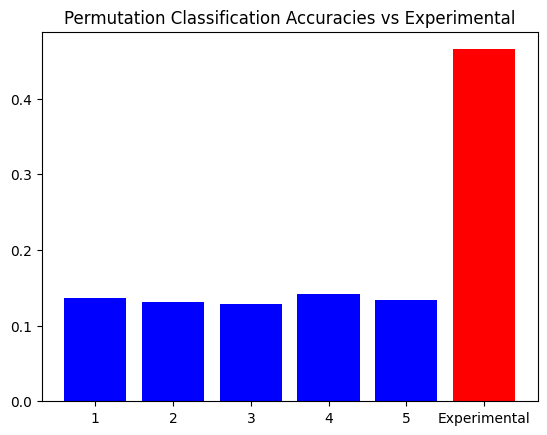

In [259]:
visualize_perm_acc = permutation_accuracies[:5] + [0.46504630325362084]
plt.title("Permutation Classification Accuracies vs Experimental")
plt.bar(x=np.arange(1,7), height=visualize_perm_acc, color=["blue"] * 5 + ["red"], tick_label=["1", "2", "3", "4", "5", "Experimental"])



### Discussion

When labels are permuted, successful classification of the object a person is looking at is around `12.5 +- 2%`. The classification accuracy we observed when the labels are not scrambled appears to be significantly higher than this range.